In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [247]:
#Define the number of elements in each set I, J, K
i_num = 25
k_num = 3
j_num = 500 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])


In [248]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
I.index

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10',
       'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'i17', 'i18', 'i19', 'i20',
       'i21', 'i22', 'i23', 'i24'],
      dtype='object', name='Point number')

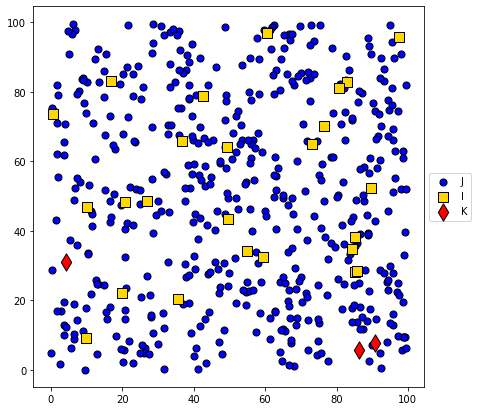

In [249]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [250]:
# from pathlib import Path
# import pandas as pd
# import geopandas as gpd
# import shapely
# #%pip install folium matplotlib mapclassify
# import folium
# import matplotlib

# # Doctor's coordinates
# doctors = {'Latitude' : [48.56500199216254, 48.5705, 48.575], 'Longitude' : [13.433214775837387, 13.436, 13.44]}
# df = pd.DataFrame(doctors)
# df

# # create geodataframe, NB CRS
# geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4386")


# with open('Polygon Passau.txt', 'r') as file:
#     # Read the contents of the file into a string
#     polygon_str = file.read()

# # Now file_contents contains the contents of the file as a string
# passau_poly = shapely.wkt.loads(polygon_str)


# passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
# passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)
# folium.GeoJson(passau_gdf).add_to(passau_map)

# geo_doctors = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Latitude"], df["Longitude"]), crs="epsg:4326")

# for idx, row in geo_doctors.iterrows():
#     folium.Marker([row['Latitude'], row['Longitude']], icon=folium.Icon(icon='circle', prefix='fa', color='blue'), 
#                   icon_size=(0.5, 0.5)).add_to(passau_map)

# lines = []
# for i in range(len(geo_doctors) - 1):
#     point1 = geo_doctors.iloc[i].geometry
#     point2 = geo_doctors.iloc[i + 1].geometry
#     lines.append([point1.coords[0], point2.coords[0]])

# folium.PolyLine(lines, color='blue').add_to(passau_map)



# passau_map

In [251]:
#Define constants

B = 100
S = 10
alpha = 10

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400
    else:
        beta[j] = 300
        
q_j = {j: 50 for j in J.index}
up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 8,
 'i1': 8,
 'i2': 8,
 'i3': 9,
 'i4': 1,
 'i5': 11,
 'i6': 4,
 'i7': 5,
 'i8': 9,
 'i9': 11,
 'i10': 5,
 'i11': 9,
 'i12': 9,
 'i13': 8,
 'i14': 4,
 'i15': 5,
 'i16': 9,
 'i17': 4,
 'i18': 3,
 'i19': 6,
 'i20': 7,
 'i21': 4,
 'i22': 6,
 'i23': 10,
 'i24': 9}

Deterministic model

In [252]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 8,
 'i1': 13,
 'i2': 5,
 'i3': 9,
 'i4': 2,
 'i5': 9,
 'i6': 3,
 'i7': 5,
 'i8': 6,
 'i9': 7,
 'i10': 6,
 'i11': 15,
 'i12': 6,
 'i13': 2,
 'i14': 5,
 'i15': 2,
 'i16': 10,
 'i17': 7,
 'i18': 3,
 'i19': 8,
 'i20': 8,
 'i21': 4,
 'i22': 5,
 'i23': 7,
 'i24': 7}

In [253]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 63.26521610569271,
 ('k0', 'j1'): 74.33557988641778,
 ('k0', 'j2'): 18.603441381099355,
 ('k0', 'j3'): 86.39629248648347,
 ('k0', 'j4'): 48.486317080595015,
 ('k0', 'j5'): 74.448788525066,
 ('k0', 'j6'): 71.07218370565238,
 ('k0', 'j7'): 65.27558283592725,
 ('k0', 'j8'): 40.72400689924802,
 ('k0', 'j9'): 25.92775521810556,
 ('k0', 'j10'): 89.82071903130146,
 ('k0', 'j11'): 87.57952999674067,
 ('k0', 'j12'): 43.78252601438158,
 ('k0', 'j13'): 60.30676968052592,
 ('k0', 'j14'): 18.09897645420867,
 ('k0', 'j15'): 94.3925343315879,
 ('k0', 'j16'): 90.6023735941835,
 ('k0', 'j17'): 66.83373440419142,
 ('k0', 'j18'): 91.85778268589982,
 ('k0', 'j19'): 17.104134071036743,
 ('k0', 'j20'): 64.33988442676906,
 ('k0', 'j21'): 79.17505449906555,
 ('k0', 'j22'): 44.92000494312084,
 ('k0', 'j23'): 72.21586230988314,
 ('k0', 'j24'): 46.00592496766042,
 ('k0', 'j25'): 31.00885082053187,
 ('k0', 'j26'): 57.744198123274685,
 ('k0', 'j27'): 90.15471105738179,
 ('k0', 'j28'): 108.0617529379

In [254]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j2'),
 ('k0', 'j4'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j12'),
 ('k0', 'j14'),
 ('k0', 'j19'),
 ('k0', 'j22'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j29'),
 ('k0', 'j31'),
 ('k0', 'j36'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j44'),
 ('k0', 'j47'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j61'),
 ('k0', 'j63'),
 ('k0', 'j65'),
 ('k0', 'j70'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j78'),
 ('k0', 'j80'),
 ('k0', 'j84'),
 ('k0', 'j94'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j99'),
 ('k0', 'j100'),
 ('k0', 'j102'),
 ('k0', 'j105'),
 ('k0', 'j106'),
 ('k0', 'j111'),
 ('k0', 'j117'),
 ('k0', 'j118'),
 ('k0', 'j119'),
 ('k0', 'j122'),
 ('k0', 'j123'),
 ('k0', 'j124'),
 ('k0', 'j132'),
 ('k0', 'j137'),
 ('k0', 'j140'),
 ('k0', 'j150'),
 ('k0', 'j151'),
 ('k0', 'j152'),
 ('k0', 'j161'),
 ('k0', 'j167'),
 ('k0', 'j168'),
 ('k0', 'j169'),
 ('k0', 'j170'),
 ('k0', 'j172'),
 ('k0

In [255]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas


[('k0', 'j2'),
 ('k0', 'j9'),
 ('k0', 'j14'),
 ('k0', 'j19'),
 ('k0', 'j22'),
 ('k0', 'j25'),
 ('k0', 'j31'),
 ('k0', 'j36'),
 ('k0', 'j44'),
 ('k0', 'j49'),
 ('k0', 'j63'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j77'),
 ('k0', 'j78'),
 ('k0', 'j80'),
 ('k0', 'j84'),
 ('k0', 'j96'),
 ('k0', 'j99'),
 ('k0', 'j102'),
 ('k0', 'j106'),
 ('k0', 'j118'),
 ('k0', 'j119'),
 ('k0', 'j122'),
 ('k0', 'j124'),
 ('k0', 'j132'),
 ('k0', 'j137'),
 ('k0', 'j140'),
 ('k0', 'j150'),
 ('k0', 'j151'),
 ('k0', 'j161'),
 ('k0', 'j176'),
 ('k0', 'j179'),
 ('k0', 'j188'),
 ('k0', 'j190'),
 ('k0', 'j192'),
 ('k0', 'j201'),
 ('k0', 'j203'),
 ('k0', 'j205'),
 ('k0', 'j216'),
 ('k0', 'j224'),
 ('k0', 'j228'),
 ('k0', 'j233'),
 ('k0', 'j244'),
 ('k0', 'j249'),
 ('k0', 'j250'),
 ('k0', 'j252'),
 ('k0', 'j256'),
 ('k0', 'j261'),
 ('k0', 'j266'),
 ('k0', 'j272'),
 ('k0', 'j291'),
 ('k0', 'j294'),
 ('k0', 'j308'),
 ('k0', 'j322'),
 ('k0', 'j333'),
 ('k0', 'j337'),
 ('k0', 'j338'),
 ('k0', 'j347'),
 ('k0', 'j348'),
 

In [256]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [257]:
model_det = gp.Model('Deterministic model')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [258]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{('k0', 'j347', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j411', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j447', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'i24', 'i24'): <gurobi.Constr *Awaiting Model Update*>}

In [259]:
model_det.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 245 rows, 13428 columns and 1008 nonzeros
Model fingerprint: 0xc615369d
Variable types: 0 continuous, 13428 integer (528 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]


  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+02]
Found heuristic solution: objective 6830.0000000
Presolve removed 151 rows and 13164 columns
Presolve time: 0.02s
Presolved: 94 rows, 264 columns, 523 nonzeros
Found heuristic solution: objective 5330.0000000
Variable types: 0 continuous, 264 integer (47 binary)

Root relaxation: objective 3.562353e+03, 127 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3562.35294    0    5 5330.00000 3562.35294  33.2%     -    0s
H    0     0                    4730.0000000 3562.35294  24.7%     -    0s
H    0     0                    4330.0000000 3562.35294  17.7%     -    0s
H    0     0                    3930.0000000 3562.35294  9.35%     -    0s
     0     0     cutoff    0      3930.00000 3930.00000  0.00%     -    0s

Cutting planes:
  Implied bound: 7
  MIR: 2
  Networ

In [260]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 5
0
3930 
x_ikj[i0,k2,i4] 8
x_ikj[i1,k2,i11] 13
x_ikj[i2,k0,j77] 5
x_ikj[i4,k1,i4] 2
x_ikj[i6,k0,j250] 3
x_ikj[i8,k0,i8] 6
x_ikj[i11,k1,i11] 14
x_ikj[i11,k2,i11] 1
x_ikj[i15,k0,i15] 2
x_ikj[i17,k0,j77] 7
x_ikj[i18,k0,j250] 3
x_ikj[i19,k0,i19] 8
x_ikj[i20,k1,i4] 8
x_ikj[i21,k1,i4] 4
x_ikj[i22,k0,j77] 5
x_ikj[i23,k2,i23] 7
x_ikj[i24,k0,i24] 7
y_j[j77] 1
y_j[j250] 1
y_j[i4] 1
y_j[i8] 1
y_j[i11] 1
y_j[i15] 1
y_j[i19] 1
y_j[i23] 1
y_j[i24] 1


1
4330 
x_ikj[i0,k2,i4] 8
x_ikj[i1,k2,i11] 13
x_ikj[i2,k0,j77] 5
x_ikj[i4,k1,i4] 2
x_ikj[i6,k0,j250] 3
x_ikj[i8,k0,i8] 6
x_ikj[i11,k1,i11] 14
x_ikj[i11,k2,i11] 1
x_ikj[i15,k0,i15] 2
x_ikj[i17,k0,j77] 7
x_ikj[i18,k0,j250] 3
x_ikj[i19,k0,i19] 8
x_ikj[i20,k1,i4] 8
x_ikj[i21,k1,i4] 4
x_ikj[i22,k0,j77] 5
x_ikj[i23,k2,i23] 7
x_ikj[i24,k0,i24] 7
y_j[j77] 1
y_j[j250] 1
y_j[i4] 1
y_j[i8] 1
y_j[i11] 1
y_j[i15] 1
y_j[i19] 1
y_j[i23] 1
y_j[i24] 1


2
4730 
x_ikj[i0,k2,i4] 8
x_ikj[i1,k2,i11] 13
x_ikj[i2,k0,j77] 5
x_ikj[i4,k1,i4] 2
x_ikj[

In [261]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations

SolutionSummary(model_det)

(      i  Number of drones
 0    i0                 8
 1    i1                13
 2   i11                15
 3   i15                 2
 4   i17                 7
 5   i18                 3
 6   i19                 8
 7    i2                 5
 8   i20                 8
 9   i21                 4
 10  i22                 5
 11  i23                 7
 12  i24                 7
 13   i4                 2
 14   i6                 3
 15   i8                 6,
       j  Number of drones
 0   i11                28
 1   i15                 2
 2   i19                 8
 3   i23                 7
 4   i24                 7
 5    i4                22
 6    i8                 6
 7  j250                 6
 8   j77                17)

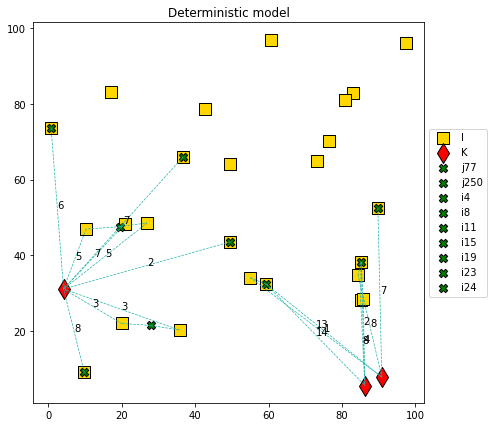

In [262]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (7, 7))
                
        fig.scatter(I['Latitude'], I['Longitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 150, label = 'I')
        fig.scatter(K['Latitude'], K['Longitude'], color = 'red', edgecolors = 'black',
                                marker = 'd', s = 200, label = 'K')
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                (K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                                #fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                #(J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longitude'], color = 'green',
                                        edgecolors = 'black', s = 70, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [263]:
for v in model_det.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',')
indices_x

['i24', 'k0', 'i24']

Probabilistic model

In [264]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.98

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 15

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [265]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [266]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [267]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')

{('k0', 'j347', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j411', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j447', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'i24', 'i24'): <gurobi.Constr *Awaiting Model Update*>}

In [268]:
model_prob.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1745 rows, 16008 columns and 3944416 nonzeros
Model fingerprint: 0xa5ccfc22
Variable types: 0 continuous, 16008 integer (3108 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+02]
Found heuristic solution: objective 7810.0000000
Presolve removed 1508 rows and 15455 columns
Presolve time: 2.90s
Presolved: 237 rows, 553 columns, 1017 nonzeros
Variable types: 0 continuous, 553 integer (162 binary)

Root relaxation: objective 2.798000e+03, 359 iterations, 0.02 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

In [269]:
ListSolution(model_prob)

Number of solutions found: 5
0
4810 
x_ikj[i0,k1,i0] 14
x_ikj[i1,k1,i1] 14
x_ikj[i2,k0,j77] 14
x_ikj[i4,k1,i0] 3
x_ikj[i6,k0,j385] 9
x_ikj[i8,k0,i8] 16
x_ikj[i11,k2,i1] 16
x_ikj[i15,k0,i15] 10
x_ikj[i17,k0,j77] 9
x_ikj[i18,k0,i18] 7
x_ikj[i19,k0,j385] 12
x_ikj[i20,k2,i0] 13
x_ikj[i21,k2,i0] 9
x_ikj[i22,k0,j77] 12
x_ikj[i23,k1,i23] 17
x_ikj[i24,k0,i24] 16
y_j[j77] 1
y_j[j385] 1
y_j[i0] 1
y_j[i1] 1
y_j[i8] 1
y_j[i15] 1
y_j[i18] 1
y_j[i23] 1
y_j[i24] 1


1
4910 
x_ikj[i0,k1,i0] 14
x_ikj[i1,k1,i1] 14
x_ikj[i2,k0,j77] 14
x_ikj[i4,k1,i0] 3
x_ikj[i6,k0,j385] 9
x_ikj[i8,k0,i8] 16
x_ikj[i11,k2,i1] 16
x_ikj[i15,k0,i15] 10
x_ikj[i17,k0,j77] 9
x_ikj[i18,k0,i18] 7
x_ikj[i19,k0,j385] 12
x_ikj[i20,k2,i0] 13
x_ikj[i21,k2,i0] 9
x_ikj[i22,k0,j77] 12
x_ikj[i23,k1,i23] 17
x_ikj[i24,k0,i24] 16
y_j[j77] 1
y_j[j385] 1
y_j[i0] 1
y_j[i1] 1
y_j[i8] 1
y_j[i15] 1
y_j[i18] 1
y_j[i23] 1
y_j[i24] 1


2
5210 
x_ikj[i0,k1,i0] 14
x_ikj[i1,k1,i1] 14
x_ikj[i2,k0,j77] 14
x_ikj[i4,k1,i0] 3
x_ikj[i6,k0,j385] 9
x_ikj[i8,k0,i

In [270]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                14
 1    i1                14
 2   i11                16
 3   i15                10
 4   i17                 9
 5   i18                 7
 6   i19                12
 7    i2                14
 8   i20                13
 9   i21                 9
 10  i22                12
 11  i23                17
 12  i24                16
 13   i4                 3
 14   i6                 9
 15   i8                16,
       j  Number of drones
 0    i0                39
 1    i1                30
 2   i15                10
 3   i18                 7
 4   i23                17
 5   i24                16
 6    i8                16
 7  j385                21
 8   j77                35)

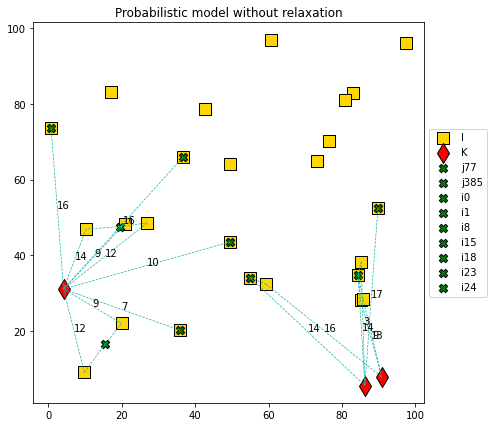

In [271]:
SolutionGraph(I, K, J, model_prob)

Probabilistic model with relaxed constraints

In [272]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 (

In [273]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j2'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j27'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j66'),
 ('k0', 'j67'),
 ('k0', 'j70'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j77'),
 ('k0', 'j78'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j82'),
 ('k0', 'j84'),
 ('k0', 'j85'),
 ('k0', 'j88'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j94'),
 ('k0', 'j96'),
 ('k0', 'j99'),
 ('k0', 'j100'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j103'),
 ('k0', 'j104'),
 ('k0', 'j106'),
 ('k0', 'j107'),
 ('k0', 'j109'),
 ('k

In [274]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [275]:
#Redefine constants and random variables


I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))

In [276]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [277]:
model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')



model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob_rel.addConstrs((dist_KJ[(k, j)] * y_j[j] <= B for (k, j) in N_i[i]), name = 'c19')

model_prob_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c20')




Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('k0', 'j33', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j33', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j100', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j130', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j130', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j136', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j136', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j144', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j144', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j145', 'i10'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j145', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j167', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j170', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j173', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j208', 'i16'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j208', 'i24'): <gu

In [278]:
model_prob_rel.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3631 rows, 39883 columns and 6779545 nonzeros
Model fingerprint: 0x7a41c48f
Variable types: 0 continuous, 39883 integer (3108 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+01]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+02]
Found heuristic solution: objective 12980.000000
Presolve removed 238 rows and 38363 columns (presolve time = 5s) ...
Presolve removed 2793 rows and 38363 columns
Presolve time: 5.48s
Presolved: 838 rows, 1520 columns, 3272 nonzeros
Variable types: 0 continuous, 1520 integer (302 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.975000e+01   0.000000e+00      6s
    1244    

In [279]:
ListSolution(model_prob_rel)

Number of solutions found: 7
0
7280 
x_ikj[i0,k2,i20] 14
x_ikj[i1,k2,j197] 14
x_ikj[i2,k1,j77] 14
x_ikj[i3,k1,i5] 16
x_ikj[i4,k0,i20] 3
x_ikj[i5,k1,i5] 18
x_ikj[i6,k0,j250] 9
x_ikj[i7,k2,i7] 10
x_ikj[i8,k0,j111] 16
x_ikj[i9,k0,j111] 18
x_ikj[i10,k0,j227] 10
x_ikj[i11,k1,j197] 16
x_ikj[i12,k1,i14] 16
x_ikj[i13,k2,i13] 14
x_ikj[i14,k0,i14] 9
x_ikj[i15,k1,j197] 10
x_ikj[i16,k1,j227] 16
x_ikj[i17,k2,j77] 9
x_ikj[i18,k0,j250] 7
x_ikj[i19,k1,i19] 12
x_ikj[i20,k1,i20] 13
x_ikj[i21,k0,i20] 9
x_ikj[i22,k1,j77] 12
x_ikj[i23,k2,i23] 17
x_ikj[i24,k2,j227] 16
y_j[j77] 1
y_j[j111] 1
y_j[j197] 1
y_j[j227] 1
y_j[j250] 1
y_j[i5] 1
y_j[i7] 1
y_j[i13] 1
y_j[i14] 1
y_j[i19] 1
y_j[i20] 1
y_j[i23] 1


1
7380 
x_ikj[i0,k2,i20] 14
x_ikj[i1,k2,j197] 14
x_ikj[i2,k1,j77] 14
x_ikj[i3,k1,i5] 16
x_ikj[i4,k0,i20] 3
x_ikj[i5,k1,i5] 18
x_ikj[i6,k0,j250] 9
x_ikj[i7,k2,i7] 10
x_ikj[i8,k0,j111] 16
x_ikj[i9,k0,j111] 18
x_ikj[i10,k0,j227] 10
x_ikj[i11,k1,j197] 16
x_ikj[i12,k1,i14] 16
x_ikj[i13,k2,i13] 14
x_ikj[i14,k0,i14] 

In [280]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                14
 1    i1                14
 2   i10                10
 3   i11                16
 4   i12                16
 5   i13                14
 6   i14                 9
 7   i15                10
 8   i16                16
 9   i17                 9
 10  i18                 7
 11  i19                12
 12   i2                14
 13  i20                13
 14  i21                 9
 15  i22                12
 16  i23                17
 17  i24                16
 18   i3                16
 19   i4                 3
 20   i5                18
 21   i6                 9
 22   i7                10
 23   i8                16
 24   i9                18,
        j  Number of drones
 0    i13                14
 1    i14                25
 2    i19                12
 3    i20                39
 4    i23                17
 5     i5                34
 6     i7                10
 7   j111                34
 8   j197                40
 9   j227        

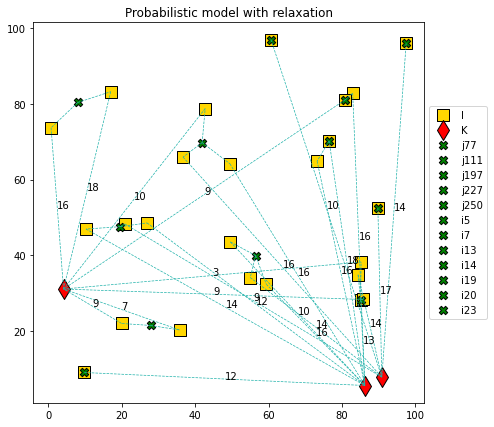

In [281]:
SolutionGraph(I, K, J, model_prob_rel)

Deterministic model with relaxed constraints

In [282]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [283]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c21')
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c22')

model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_det_rel.addConstrs((dist_KJ[(k, j)] * y_j[j] <= B for (k, j) in N_i[i]), name = 'c19')

model_det_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c25')

model_det_rel.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1075 rows, 37303 columns and 3481 nonzeros
Model fingerprint: 0xbdc56beb
Variable types: 0 continuous, 37303 integer (528 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+02]
Found heuristic solution: objective 11520.000000
Presolve removed 911 rows and 36899 columns
Presolve time: 0.10s
Presolved: 164 rows, 404 columns, 861 nonzeros
Found heuristic solution: objective 7020.0000000
Variable types: 0 continuous, 404 integer (53 binary)

Root relaxation: objective 5.274902e+03, 311 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth I

In [284]:
ListSolution(model_det_rel)

Number of solutions found: 4
0
5720 
x_ikj[i0,k0,i4] 7
x_ikj[i0,k1,i4] 1
x_ikj[i1,k0,j197] 8
x_ikj[i1,k1,j197] 5
x_ikj[i2,k1,j77] 5
x_ikj[i3,k1,i5] 6
x_ikj[i3,k2,i5] 3
x_ikj[i4,k1,i4] 2
x_ikj[i5,k0,i5] 6
x_ikj[i5,k2,i5] 3


x_ikj[i6,k1,j385] 3
x_ikj[i7,k2,i7] 5
x_ikj[i8,k0,j111] 6
x_ikj[i9,k0,j111] 7
x_ikj[i10,k2,j227] 6
x_ikj[i11,k1,j197] 5
x_ikj[i11,k2,j197] 10
x_ikj[i12,k1,i14] 6
x_ikj[i13,k2,i13] 2
x_ikj[i14,k1,i14] 5
x_ikj[i15,k0,j197] 2
x_ikj[i16,k2,j227] 10
x_ikj[i17,k1,j77] 7
x_ikj[i18,k2,i18] 3
x_ikj[i19,k0,j385] 3
x_ikj[i19,k1,j385] 4
x_ikj[i19,k2,j385] 1
x_ikj[i20,k1,i4] 1
x_ikj[i20,k2,i4] 7
x_ikj[i21,k0,i4] 4
x_ikj[i22,k2,j77] 5
x_ikj[i23,k0,i23] 7
x_ikj[i24,k1,j227] 7
y_j[j77] 1
y_j[j111] 1
y_j[j197] 1
y_j[j227] 1
y_j[j385] 1
y_j[i4] 1
y_j[i5] 1
y_j[i7] 1
y_j[i13] 1
y_j[i14] 1
y_j[i18] 1
y_j[i23] 1


1
5820 
x_ikj[i0,k0,i4] 7
x_ikj[i0,k1,i4] 1
x_ikj[i1,k0,j197] 8
x_ikj[i1,k1,j197] 5
x_ikj[i2,k1,j77] 5
x_ikj[i3,k1,i5] 6
x_ikj[i3,k2,i5] 3
x_ikj[i4,k1,i4] 2
x_ikj[i5,k0,i5] 6
x_ikj[i5,k2,i5] 3
x_ikj[i6,k1,j385] 3
x_ikj[i7,k2,i7] 5
x_ikj[i8,k0,j111] 6
x_ikj[i9,k0,j111] 7
x_ikj[i10,k2,j227] 6
x_ikj[i11,k1,j197] 5
x_ikj[i11,k2,j197] 10
x_ikj[i12,k1,i14] 6
x_ikj[i13,k2,i13] 2
x_ikj[i14,k1,i14] 5
x_ik

In [285]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                 8
 1    i1                13
 2   i10                 6
 3   i11                15
 4   i12                 6
 5   i13                 2
 6   i14                 5
 7   i15                 2
 8   i16                10
 9   i17                 7
 10  i18                 3
 11  i19                 8
 12   i2                 5
 13  i20                 8
 14  i21                 4
 15  i22                 5
 16  i23                 7
 17  i24                 7
 18   i3                 9
 19   i4                 2
 20   i5                 9
 21   i6                 3
 22   i7                 5
 23   i8                 6
 24   i9                 7,
        j  Number of drones
 0    i13                 2
 1    i14                11
 2    i18                 3
 3    i23                 7
 4     i4                22
 5     i5                18
 6     i7                 5
 7   j111                13
 8   j197                30
 9   j227        

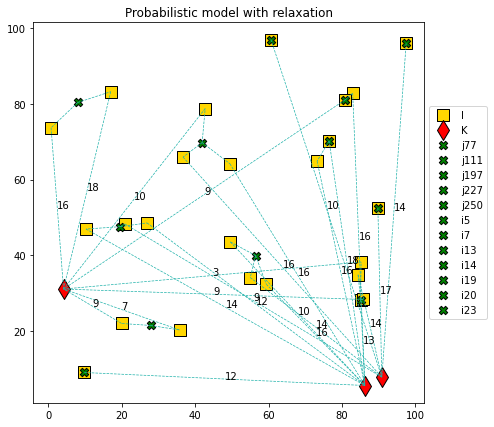

In [286]:
SolutionGraph(I, K, J, model_prob_rel)

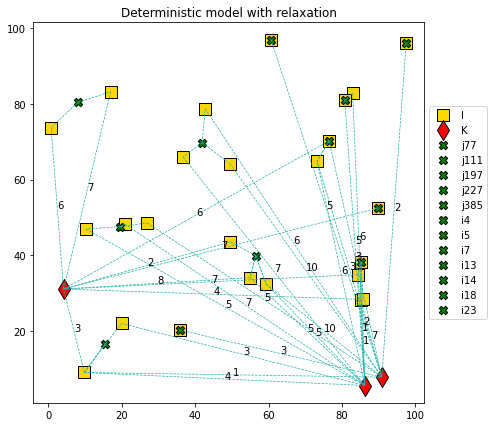

In [287]:
SolutionGraph(I, K, J, model_det_rel)

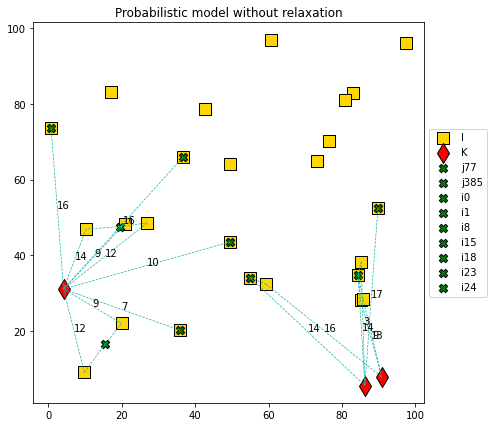

In [288]:
SolutionGraph(I, K, J, model_prob)

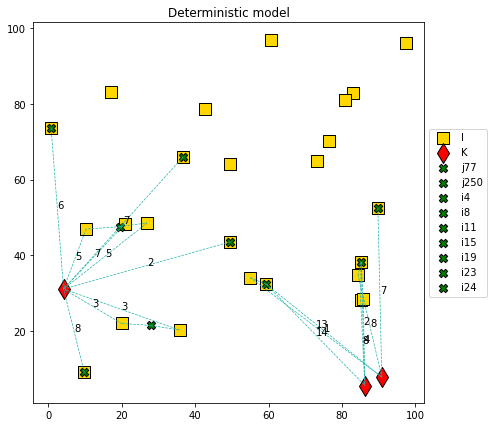

In [289]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty